In [115]:
import pandas as pd 
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
data = pd.read_csv('HURdat_ExtremeWeatherEvents.csv')
data = data[list(data.columns)[1:]]
data.head(10)

,ID,Name,Status,Latitude,Longitude,Maximum.Wind,date_time,diff,rapid_int,i,...,persistence,product,Initial.Max,speed,speed_z,speed_m,Jday,Maximum.Wind_p,Latitude_p,Longitude_p
0,AL011980,UNNAMED,TD,30.5,-76.5,20,7/17/1980 0:00,NaN,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,55,NaN,NaN,NaN
1,AL011980,UNNAMED,TD,30.2,-77.2,25,7/17/1980 6:00,NaN,NaN,2,...,NaN,NaN,20.0,NaN,NaN,NaN,55,20.0,30.5,-76.5
2,AL011980,UNNAMED,TD,30.0,-78.0,25,7/17/1980 12:00,NaN,NaN,3,...,NaN,NaN,25.0,NaN,NaN,NaN,55,25.0,30.2,-77.2
3,AL011980,UNNAMED,TD,29.9,-79.3,25,7/17/1980 18:00,NaN,NaN,4,...,5.0,125.0,25.0,12.869511,0.035365,9.266244,55,25.0,30.0,-78.0
4,AL011980,UNNAMED,TD,29.8,-80.2,25,7/18/1980 0:00,5.0,0.0,5,...,0.0,0.0,25.0,17.071172,0.035158,9.266244,54,25.0,29.9,-79.3
5,AL011980,UNNAMED,TD,29.5,-81.1,25,7/18/1980 6:00,0.0,0.0,6,...,0.0,0.0,25.0,17.768950,0.035018,9.266244,54,25.0,29.8,-80.2
6,AL011980,UNNAMED,TD,29.5,-82.0,20,7/18/1980 12:00,-5.0,0.0,7,...,0.0,0.0,25.0,14.954518,0.034947,9.266244,54,25.0,29.5,-81.1
7,AL011980,UNNAMED,TD,29.5,-84.7,20,7/19/1980 6:00,-5.0,0.0,10,...,0.0,0.0,25.0,16.164193,0.034660,9.266244,53,20.0,29.4,-84.0
8,AL011980,UNNAMED,TD,29.6,-85.8,25,7/19/1980 12:00,5.0,0.0,11,...,0.0,0.0,25.0,13.748279,0.034587,9.266244,53,20.0,29.5,-84.7
9,AL011980,UNNAMED,TD,29.7,-86.4,25,7/19/1980 18:00,5.0,0.0,12,...,5.0,125.0,25.0,14.634529,0.034587,9.266244,53,25.0,29.6,-85.8


In [102]:
# Pandas(Index=153, ID='AL011993', Name='UNNAMED', Status='TD', 
# Latitude=26.7, Longitude=-74.0, _6=30, date_time='6/2/1993 0:00', 
# diff=5.0, rapid_int=0.0, i=7, n=11, persistence=5.0, product=150.0, 
# _14=30.0, speed=30.632630100000004, speed_z=0.030517206, speed_m=9.266243887, 
# Jday=101, _19=30.0, Latitude_p=26.1, Longitude_p=-75.8)

# max distinct 8372 states
triples = set()
previous_status = None
previous_name = None
is_escalated = False
states = set()
for state in data.itertuples():
    # Skip if we don't have the data
    if str(state.speed) == 'nan' or str(state.product) == 'nan':
        continue
    # Get the name
    name = state.ID
    # Features
    latitude = float(state.Latitude)
    longitude = float(state.Longitude)
    speed = float(state.speed)
    product = float(state.product)
    st = state.Status
    # Create a status string
    status = "state_{lat}_{long}_{speed}_{product}".format(
        lat=round(latitude / 10.0),
        long=round(longitude / 10.0),
        speed=round(speed),
        product=round(product)
    )
    # Describe
    triples.add('{s},{p},{o}'.format(s=status, p='has_status', o=st))    
    # Add extra triple to connect the statuses
    lat = 'lat_{}'.format(round(latitude))
    lat_zone = 'lat_zone_{}'.format(round(latitude / 10.0))
    triples.add('{s},{p},{o}'.format(s=status, p='has_lat', o=lat))
    triples.add('{s},{p},{o}'.format(s=lat, p='in_lat_zone', o=lat_zone))
    long = 'long_{}'.format(round(longitude))
    long_zone = 'long_zone_{}'.format(round(longitude / 10.0))
    triples.add('{s},{p},{o}'.format(s=status, p='has_long', o=long))
    triples.add('{s},{p},{o}'.format(s=long, p='in_long_zone', o=long_zone))
    sp = 'speed_{}'.format(round(speed))
    sp_zone = 'speed_zone_{}'.format(round(speed / 10.0))
    triples.add('{s},{p},{o}'.format(s=status, p='has_speed', o=sp))
    triples.add('{s},{p},{o}'.format(s=sp, p='in_speed_zone', o=sp_zone))    
    # Add the triples to link the states and prepare for next
    if previous_name != name:
        previous_name = None
    if previous_status != None and previous_name == name:
        p = 'escalate_to' if (str(state.rapid_int)=='1.0' and not is_escalated) else 'transit_to'
        triples.add('{s},{p},{o}'.format(s=previous_status, p=p, o=status))
    previous_status = status
    previous_name = name
    is_escalated = str(state.rapid_int)=='1.0'
    states.add(state)
print (len(states))
print (len(triples))

7515
30567


In [103]:
df = pd.DataFrame([r.split(',') for r in triples], columns=['s', 'p', 'o'])
df.to_csv('triples.csv', index=False)
df

,s,p,o
0,state_4_-7_17_1050,transit_to,state_4_-7_19_1125
1,state_2_-10_12_200,has_long,long_-96
2,state_2_-8_8_600,has_lat,lat_20
3,state_1_-7_36_0,has_status,TD
4,state_2_-4_16_250,has_speed,speed_16
...,...,...,...
30562,state_2_-9_23_275,has_lat,lat_17
30563,state_1_-4_35_150,has_lat,lat_13
30564,state_3_-10_9_0,has_lat,lat_30
30565,state_4_-7_37_650,has_status,HU


In [104]:
from ampligraph.latent_features import ComplEx

In [105]:
X = [r.split(',') for r in triples if r.split(',')[1] != 'escalate_to']
escalated = [r for r in triples if r.split(',')[1] == 'escalate_to']
to_predict = random.sample(escalated, int(round(len(escalated) / 2.0)))
for e in escalated:
    if e not in set(to_predict):
        X.append(e.split(','))
X = np.array(X)
Y = np.array([r.split(',') for r in to_predict])

In [106]:
model = ComplEx(batches_count=2, seed=555, epochs=5000, k=10, verbose=True)
model.fit(X)

Average Loss:   0.196660: 100%|██████████| 5000/5000 [06:25<00:00, 12.98epoch/s]


In [127]:
model.calibrate(X, positive_base_rate=0.99)
just_get_data = model.predict_proba(Y)
print (just_get_data)

Calibration Loss:   0.004709: 100%|██████████| 50/50 [00:04<00:00, 11.76epoch/s]


[0.01172912 0.99884975 0.8926959  0.43544134 0.91796565 0.06010029
 0.99783564 0.87853336 0.9829193  0.7401136  0.12951359 0.6013794
 0.04015645 0.62138116 0.9745018  0.994882   0.07022476 0.64780444
 0.3084737  0.9999486  0.86472297 0.59180796 0.7874174  0.94838
 0.94056094 0.98005736 0.7132235  0.9807782  0.5792216  0.99475574
 0.04626465 0.15693983 0.1208491  0.96516013 0.6525599  0.85397846
 0.8459382  0.0850617  0.83699596 0.9707886  0.0552997  0.0248889
 0.8561949  0.9029052  0.9931551  0.10891965 0.6022793  0.45379174
 0.82251596 0.61954993 0.9883264  0.01207453 0.1662158  0.792811
 0.7707101  0.99671936 0.9956256  0.6467333  0.95299864 0.9523039
 0.6595569  0.96188724 0.9981319  0.9873103  0.9696332  0.62556887
 0.99960417 0.59086055 0.78603065 0.25841683 0.30979872 0.9976765
 0.9501656  0.04165635 0.6769265  0.16058683 0.9159571  0.9500382
 0.03133783 0.99984145 0.12250018 0.09689504 0.16484323 0.22043374
 0.8612498  0.01899883 0.00829589 0.9836699  0.36334062 0.10202044
 0.25

(array([15.,  8.,  3.,  4.,  2.,  5.,  8.,  6.,  9., 37.]),
 array([0.00829589, 0.10746117, 0.20662645, 0.3057917 , 0.404957  ,
        0.50412226, 0.6032875 , 0.7024528 , 0.8016181 , 0.90078336,
        0.9999486 ], dtype=float32),
 <a list of 10 Patch objects>)

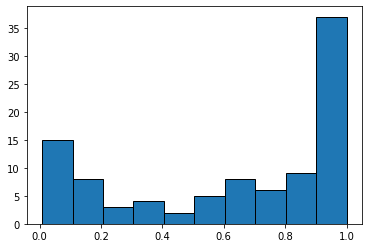

In [128]:
#plt.grid(True)
plt.hist(just_get_data, edgecolor='black')